# VQQ Lab


**Primary Notebook Authors: Duc Hoang,  Philip Harris (MIT)**

**Submission author: Tenzin Jampa**

**Date: 9/1/2022**

---

In [1]:
# First let's import what we need for our lab first
# uproot High energy physics python file format => https://masonproffitt.github.io/uproot-tutorial/aio.html
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from scipy.optimize import curve_fit
import scipy.stats as stats

#plotting style for High Energy physics 
import lmfit as lm
import mplhep as hep
plt.style.use(hep.style.CMS)

### Loading the data

Here is some codes to load the correct data sets!

In [2]:
# Now lets look at the data. Our data sample is the JetHT dataset. 
# What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data   = uproot.open("data/JetHT_s.root")["Tree"]

# In addition to above we have Monte Carlo Simulation of many processes
# Some of these process are well modelled in simulation and some of them are not
#-------------------------------------------------------------------------------

# Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq    = uproot.open("data/WQQ_s.root")["Tree"]

# Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq    = uproot.open("data/ZQQ_s.root")["Tree"] 

#Hint: You could check for files in the data directory by doing "!ls data/" in a cell.
#The ZQQ file name is similar to WQQ

# Unfortunately the samples I made above a long time ago are very small. 
# To train NNs and make nice plots we will use larger samples produced at a different collision energy
# qq=>W=>qq at 13TeV collision energy
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]

# qq=>Z=>qq at 13TeV collision energy
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]

# Now we have our worst modeled background this is also our main background. 
# This is is our di-jet quark and gluon background. 
# We just call these backgrounds QCD because they are produced with Quantum Chromo Dynamics. 
qcd    = uproot.open("data/QCD_s.root")["Tree"]

# Now we have the Higgs boson sample (we might need this in the future)
ggh    = uproot.open("data/ggH.root")["Tree"]

# And top-quark pair production background. 
tt     = uproot.open("data/TT.root")["Tree"]

# Finally we have the rarer double W, W+Z and Z+Z diboson samples where we have two bosons instead of one
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]

## Simple helper functions

After loading the data, you are provided with some simple helper functions that have already been used in our introduction notebook. These are used for pre-selection (standard cuts that physicsists usually apply before making measurements) and computing the scaling factor of datasets. You can review the previous notebook for further explanations!

In [3]:
def selection(iData):
    '''
    Standard pre-selection
    '''
    #lets apply a trigger selection
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)

    #Now lets require the jet pt to be above a threshold (400 TODO: ASK about units)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)

    #Lets apply both jetpt and trigger at the same time
    #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
    allcuts = np.logical_and.reduce([trigger,jetpt])

    return allcuts
    
def get_weights(iData,weights,sel):
    
    weight = weights[0]
    
    for i in range(1,len(weights)):
        weight *= iData.arrays(weights[i],library="np")[weights[i]][sel]
        
    return weight

def integral(iData,iWeights):
    '''
    This computs the integral of weighted events 
    assuming a selection given by the function selection (see below)
    '''
    
    #perform a selection on the data (
    mask_sel=selection(iData)
    
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    
    for i0 in range(1,len(iWeights)):
        weightarr = iData.arrays(iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        
        #multiply the weights
        weight    = weight*weightarr
    
    #now take the integral and return it
    return np.sum(weight)


def scale(iData8TeV,iData13TeV,iWeights):
    '''
    This computes the integral of two selections for two datasets labelled 8TeV and 13TeV,
    but really can be 1 and 2. Then it returns the ratio of the integrals
    '''
    
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    
    return int_8TeV/int_13TeV

-----

# 0. Find the W Peak

In this section, we provide you with some example codes to investigate the W peak. In the next section, we will ask you to fit it. First, let's make a plot of the data without any cuts. 

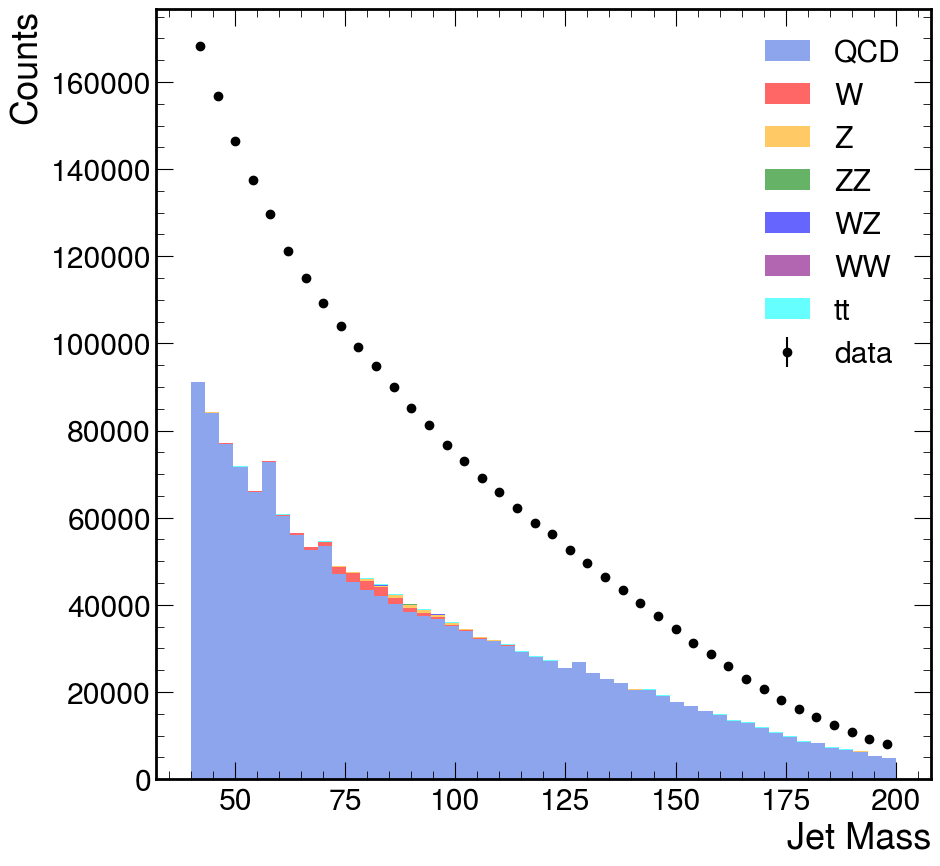

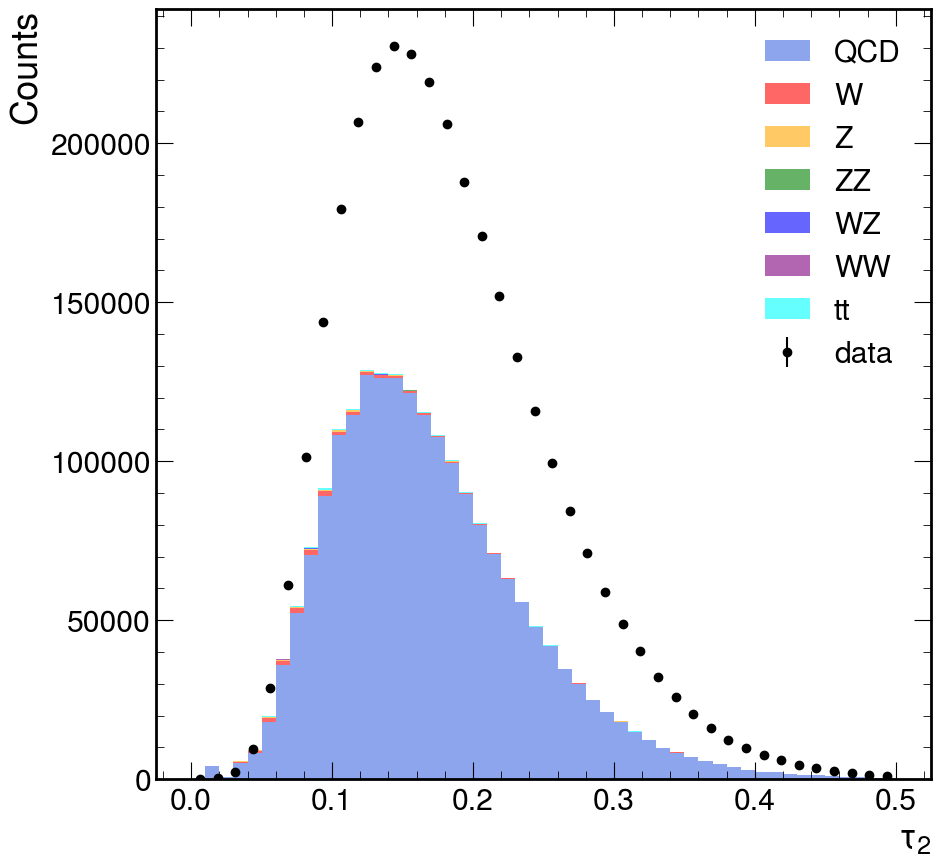

In [4]:
def plotDataSim(iVar, iSelection, iVarName, iRange):
    
    #Lets Look at the mass
    weights = [1000*18300, "puweight", "scale1fb"]
    mrange = iRange #range for mass histogram [GeV]
    bins=40            #bins for mass histogram
    density = False     #to plot the histograms as a density (integral=1)

    qcdsel      = iSelection(qcd)
    wsel        = iSelection(wqq13)
    zsel        = iSelection(zqq13)
    datasel     = iSelection(data)
    ttsel       = iSelection(tt)
    wwsel       = iSelection(ww)
    wzsel       = iSelection(wz)
    zzsel       = iSelection(zz)
    gghsel      = iSelection(ggh)

    wscale=scale(wqq,wqq13,weights)
    zscale=scale(zqq,zqq13,weights)

    # Getting the masses of selected events
    dataW = data.arrays(iVar, library="np") [iVar][datasel]
    qcdW  = qcd.arrays(iVar, library="np")  [iVar][qcdsel]
    wW    = wqq13.arrays(iVar, library="np")[iVar][wsel]
    zW    = zqq13.arrays(iVar, library="np")[iVar][zsel]
    zzW   = zz   .arrays(iVar, library="np")[iVar][zzsel]
    wzW   = wz   .arrays(iVar, library="np")[iVar][wzsel]
    wwW   = ww   .arrays(iVar, library="np")[iVar][wwsel]
    ttW   = tt   .arrays(iVar, library="np")[iVar][ttsel]
    gghW  = ggh  .arrays(iVar, library="np")[iVar][gghsel]

    #Define the weights for the histograms
    hist_weights = [get_weights(qcd,weights,qcdsel),
                    get_weights(wqq13,weights,wsel)*wscale,
                    get_weights(zqq13,weights,zsel)*zscale,
                    get_weights(zz,weights,zzsel),
                    get_weights(wz,weights,wzsel),
                    get_weights(ww,weights,wwsel),
                    get_weights(tt,weights,ttsel),
                   ]

    #Hint: Provide a list of selected data
    plt.hist([qcdW,wW, zW, zzW, wzW, wwW, ttW],
             color=["royalblue","r", "orange","g", "b", "purple", "cyan",], 
             label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt",], 
             weights=hist_weights,
             range=mrange, bins=50, alpha=.6, density=density,stacked=True)

    #Other configurations for the histogram
    counts, bins = np.histogram(dataW, bins=bins, range=mrange, density=density)
    yerr = np.sqrt(counts) / np.sqrt(len(dataW)*np.diff(bins))
    binCenters = (bins[1:]+bins[:-1])*.5
    plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
    plt.legend()
    plt.xlabel(iVarName)
    plt.ylabel("Counts")
    plt.show()

plotDataSim("vjet0_msd0", selection, "Jet Mass", [40,200])
plotDataSim("vjet0_t2", selection, r"$\tau_2$", [0,0.5]) 
#Add some code here to compare variables


When we want to compare variables, we plot the variable, the optimal cut is often at the point where the signal and background cross. As a example look at the plot below, we see that the $\tau_2/\tau_1$ point cuts at around 0.5. 

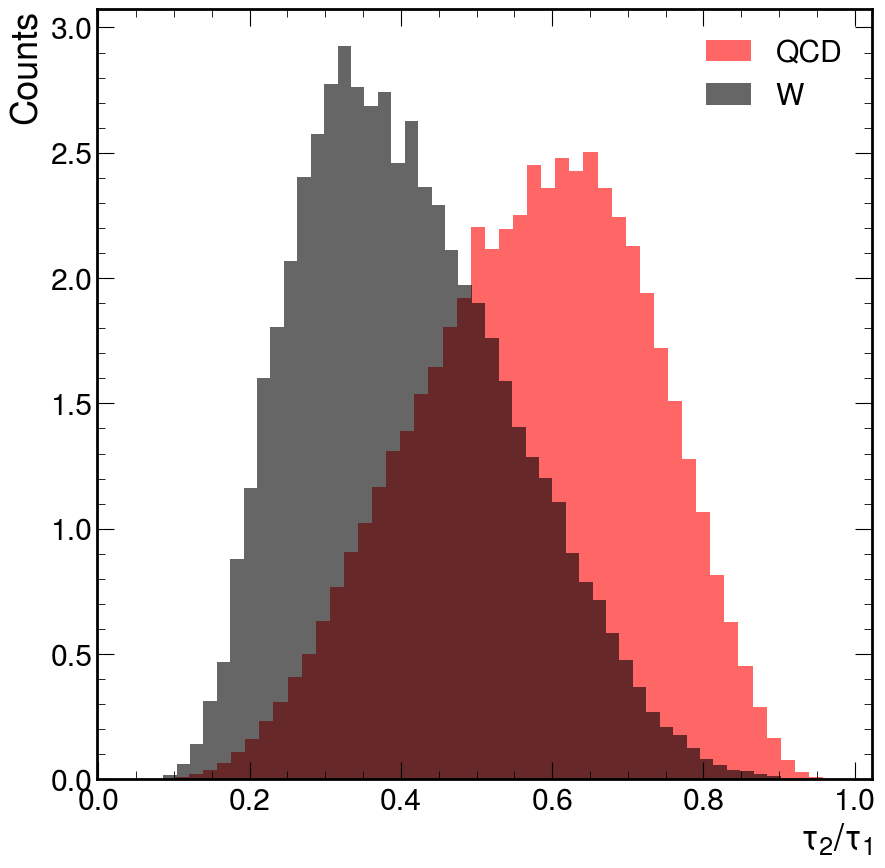

In [8]:
def plot_tau21():
    
    #Lets Look at the mass
    weights = [1000*18300, "puweight", "scale1fb"]

    qcdsel      = selection(qcd)
    wsel        = selection(wqq13)

    wscale=scale(wqq,wqq13,weights)

    # Getting the masses of selected events
    qcd_t21  = (qcd.arrays('vjet0_t2', library="np")['vjet0_t2'][qcdsel]/
               qcd.arrays('vjet0_t1', library="np")['vjet0_t1'][qcdsel])
    
    w_t21    = (wqq13.arrays('vjet0_t2', library="np")['vjet0_t2'][wsel]/
               wqq13.arrays('vjet0_t1', library="np")['vjet0_t1'][wsel])

    plt.hist(qcd_t21,
             weights=get_weights(qcd,weights,qcdsel),
             bins=50,
             color='red',
             label="QCD", alpha=.6, density = True)
    
    plt.hist(w_t21,
             weights=get_weights(wqq13,weights,wsel)*wscale,
             bins=50,
             color='black',
             label="W", alpha=.6, density = True)

    #Other configurations for the histogram
    plt.legend()
    plt.xlabel(r"$\tau_{2}/\tau_{1}$")
    plt.ylabel("Counts")
    plt.show()

plot_tau21()

In [4]:
def selectionW(iData):
    '''
    This is the specific selection for selecting out events with W signal for our analysis
    '''
    
    #Pre-selection citeria
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
    
    #Select the jets to compute tau2/tau1
    jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
    jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
    
    t21 = jett2/jett1
                                
    #And then perform the cut
    #Hint: You could determine the threshold of the cut by plotting the distribution of 
    #t21ddt scores for W and background and then determine a ball park threshold
    #where you think the W signal would be best selected
    #Or more simply you could look at the given plot and determine the appropriate threshold.
    
    t21cut   = t21 < 0.5 #eyeballing it
    
    allcuts = np.logical_and.reduce([trigger, jetpt, t21cut])
    
    return allcuts

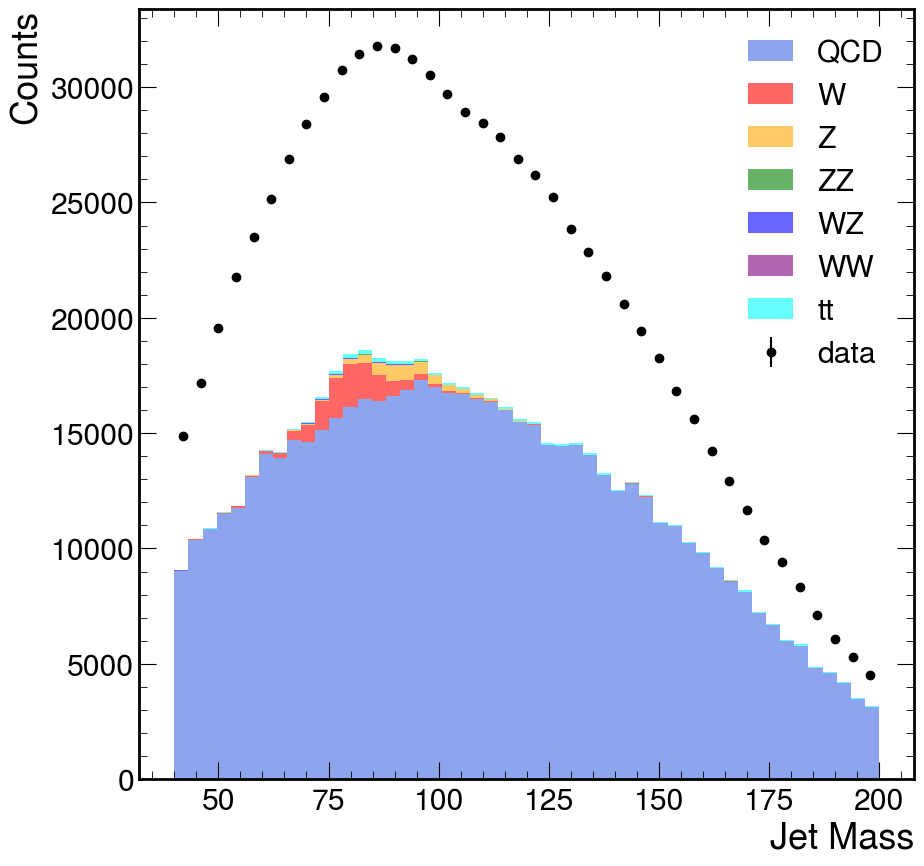

In [8]:
plotDataSim("vjet0_msd0", selectionW, "Jet Mass",[40,200])

Looking at this plot, we can see that the W peak is not at all obvious to find! This is why we need to employ additional techniques in order to clearly identify the W peak, which is what you'll have the chance to do in the next section!

# 1. Fit for W Peak

Now, lets do the lab. <font color="blue"> Your first challenge is to make a mass plot and perform fitting for W signal. </font> A hint is that the plots should come out similarly to this (it doesn't have to be exactly the same), where on the left we show the soft-drop mass/groomed mass ($m_{SD}$) distribution for different processes in the Monte Carlo simulation along with the real data. The plot on the right shows the fit:

<img src="images/S50_WFit.png" width='900'>

## 1.1 W Mass Plot

Since finding W peak is hard, we need to use another parameter, $\rho$, which is a scaling variable for QCD jets. This parameter adds another channels of mass and $p_T$ to our selection, helping us to refine our W peak.

$\rho$ is defined in this paper:

https://arxiv.org/pdf/1603.00027.pdf

Your first goal is to figure out how $\rho$ is defined by quoting the paper, and then figure out the best selections based on a combination of $\rho$ and $\tau_2/\tau_1$. The final cut is based on a parameter defined as *DT* (Deccorelated Taggers) score:

$$(\tau_2/\tau_1)_{dt} = \tau_2/\tau_1 - (\text{your correlation})*\rho$$

Where the correlation **<em> your correlation </em>** is the correlation coefficient between $\tau_2/\tau_1$ and $\rho$. 

To figure out the correlation, let's plot $\tau_2/\tau_1$ and $\rho$ in the data first!

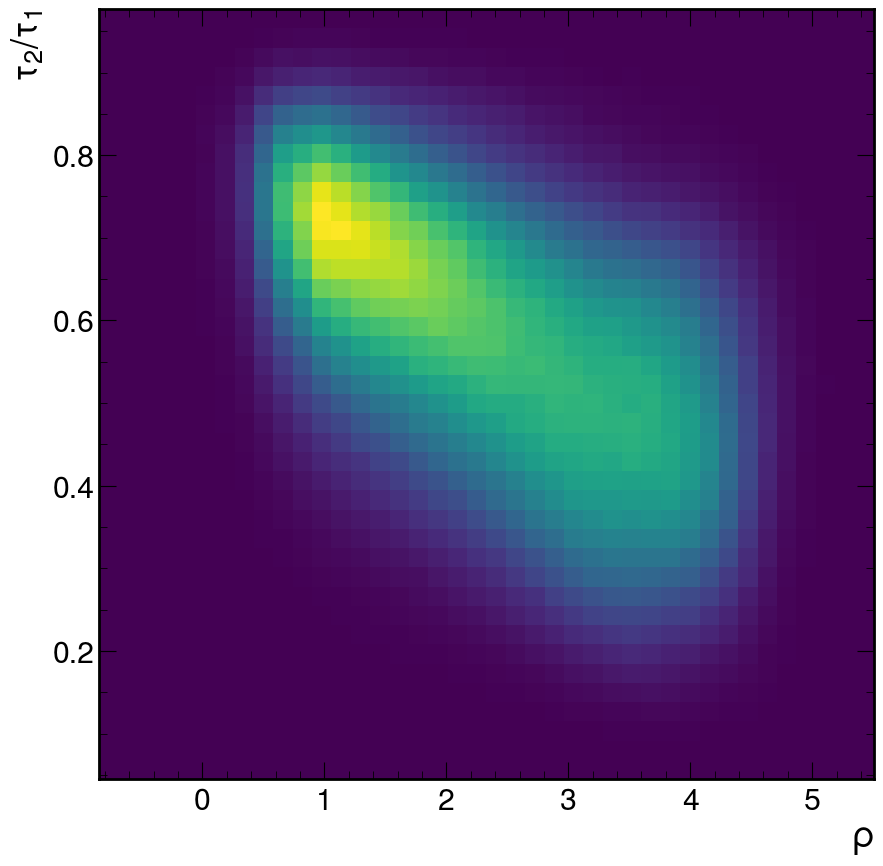

In [30]:
def plot_taus_and_rho(iData):
    
    jetptnocut = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
    jetmass = (iData.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
    jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
    jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
    
    #Define rho according to the paper
    rho = np.log(jetmass**2/jetptnocut) #this is actually rho prime, setting mu~1 Gev
    
    #Define tau2/tau1
    t21 = jett2/jett1 # The ratio
    
    plt.hist2d(rho, t21, bins = 40)
    
    plt.xlabel(r"$\rho$")
    plt.ylabel(r"$\tau_2/\tau_1$")
    plt.show()
    
plot_taus_and_rho(qcd)

This is how the 2d histogram of t2/t1 to rho looks of the qcd background data. On the contrary, let's take a look at how a similar plot looks for the signal data for W and Z.

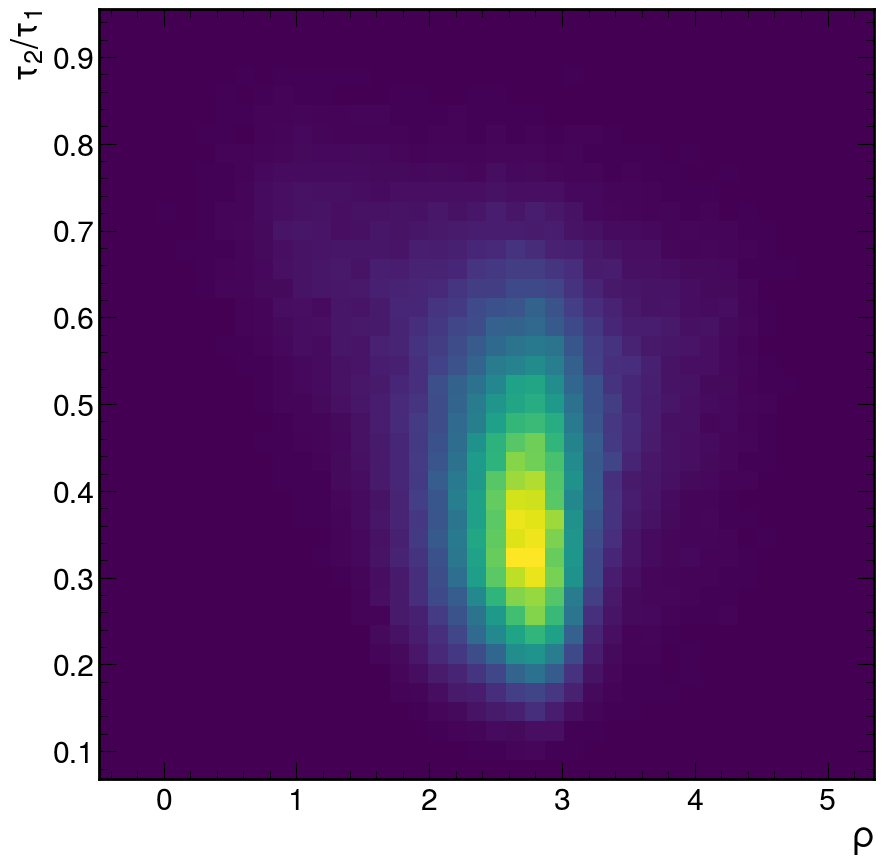

In [29]:
plot_taus_and_rho(wqq13)

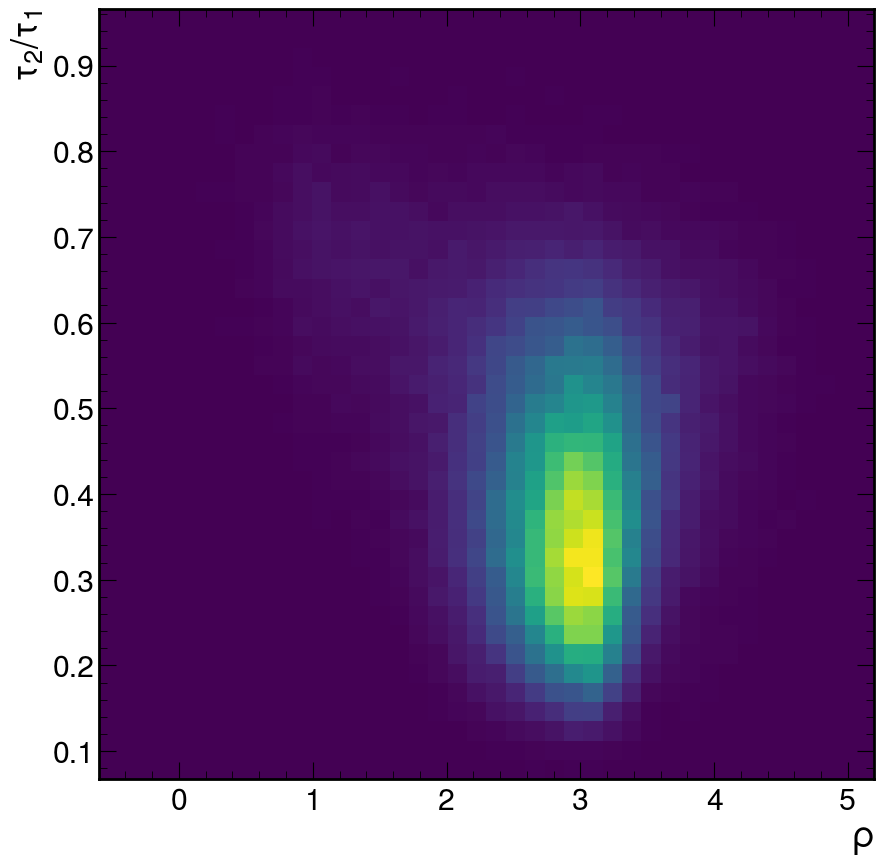

In [90]:
plot_taus_and_rho(zqq13)

-----

Great! Now we can fit a line on the 2D histogram to determine the correlation for the background data! The following code fits by putting a threshold on the 2D histogram to selectively fit on the most relevant data points, your task for this is to play around with the threshold to determine the best fit!

[-0.08931938  0.79891476] [[ 2.41327490e-05 -5.19108392e-05]
 [-5.19108392e-05  1.30980755e-04]]


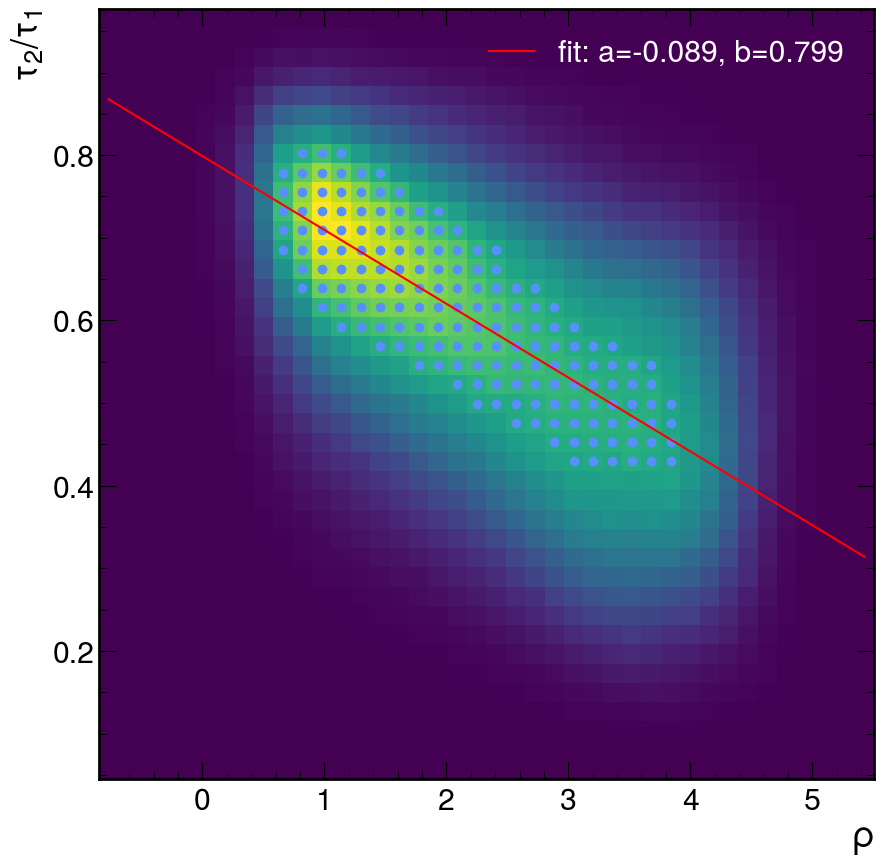

In [31]:
def fit_correlation(iData):
    
    jetptnocut = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
    jetmass = (iData.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
    jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
    jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
    
    #Define rho according to the paper
    rho = np.log(jetmass**2/jetptnocut)
    
    #Define tau2/tau1
    t21 = jett2/jett1
    
    plt.hist2d(rho, t21, bins = 40)
    plt.xlabel(r"$\rho$")
    plt.ylabel(r"$\tau_2/\tau_1$")
    
    #Fit the line
    #Produce 2D histogram
    H,xedges,yedges = np.histogram2d(rho,t21, bins=40,density = True)
    
    bin_centers_x = (xedges[:-1]+xedges[1:])/2.0
    bin_centers_y = (yedges[:-1]+yedges[1:])/2.0
    
    #Find the non-zero indicies
    non_zero_idx = np.argwhere(H > 0.6) #You can play around with this! 
    #H is the bin density. This is the threshold
    x_idx = non_zero_idx[:,0]
    y_idx = non_zero_idx[:,1]
    
    x_coord = [bin_centers_x[x_idx[i]] for i in range(0,len(x_idx))]
    y_coord = [bin_centers_y[y_idx[i]] for i in range(0,len(y_idx))]
    
    #Fit a linear model on the points plotted
    def func(x, a, b):
        return a * x + b
    plt.scatter(x_coord, y_coord)
    
    popt, pcov = curve_fit(func, x_coord, y_coord)
    print(popt, pcov)
    plt.plot(bin_centers_x, func(bin_centers_x, *popt), 'r-',
             label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    
    #Show the fit result
    legend = plt.legend()
    plt.setp(legend.get_texts(), color='w')
    plt.show()
    

fit_correlation(qcd)

[-0.00216966  0.41254424] [[ 0.00076858 -0.00203823]
 [-0.00203823  0.00549587]]


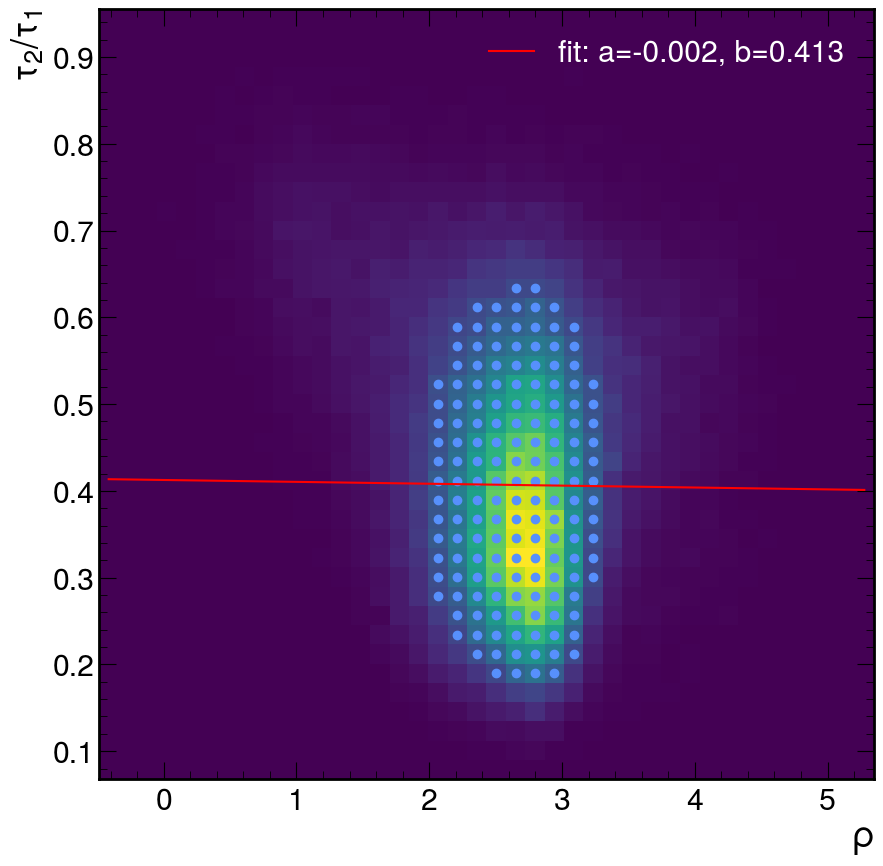

In [33]:
fit_correlation(wqq13)

Now use the correlation to define $(\tau_2/\tau_1)_{dt}$ and plot it with $\rho$ to verify that we have successfully decorrelate the tagger! (you should see a straight-line distribution in the histogram).

[3.19430972e-04 7.98852312e-01] [[ 3.23346479e-05 -6.86973292e-05]
 [-6.86973292e-05  1.71871071e-04]]


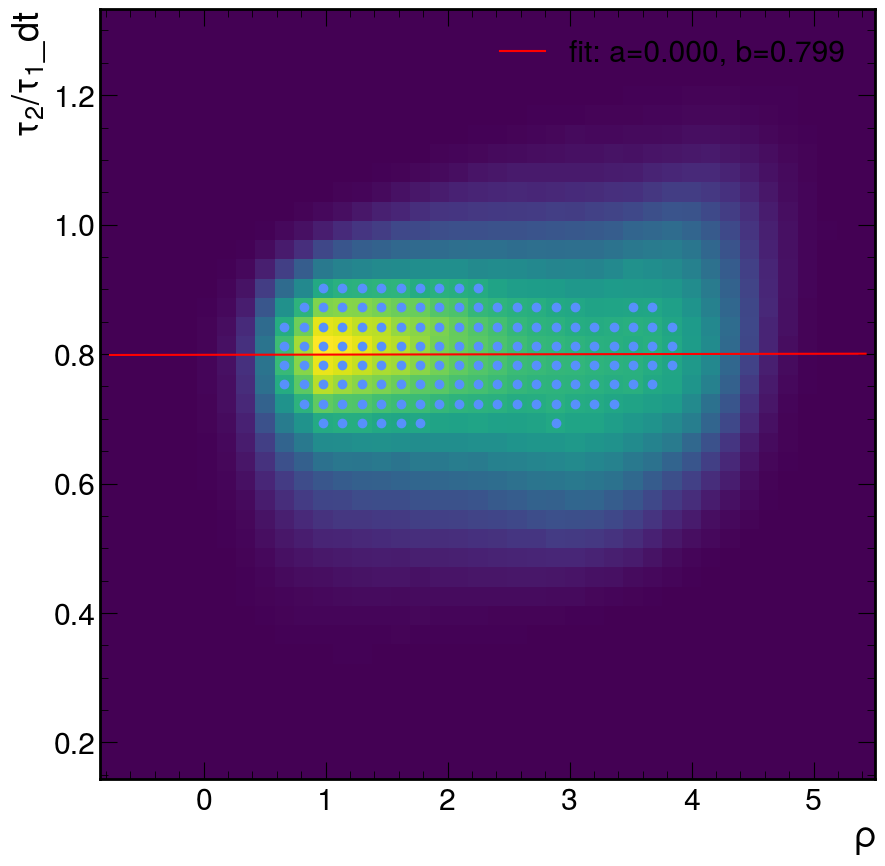

In [32]:
def plot_tausdt_and_rho(iData, fit  = False):
    
    jetptnocut = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
    jetmass = (iData.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
    jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
    jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
    
    #Define rho according to the paper
    rho = np.log(jetmass**2/jetptnocut)
    
    #Define tau2/tau1
    t21 = jett2/jett1 
    
    #decorrelated tagger score
    t21dt = t21 - (-0.089)*rho #Your decorrelated tagger score definition
    
    plt.hist2d(rho, t21dt, bins = 40)
    if fit:
        #Fit the line
        #Produce 2D histogram
        H,xedges,yedges = np.histogram2d(rho,t21dt, bins=40,density = True)
        
        bin_centers_x = (xedges[:-1]+xedges[1:])/2.0
        bin_centers_y = (yedges[:-1]+yedges[1:])/2.0
        
        #Find the non-zero indicies
        non_zero_idx = np.argwhere(H > 0.6) #You can play around with this! 
        #H is the bin density. This is the threshold
        x_idx = non_zero_idx[:,0]
        y_idx = non_zero_idx[:,1]
        
        x_coord = [bin_centers_x[x_idx[i]] for i in range(0,len(x_idx))]
        y_coord = [bin_centers_y[y_idx[i]] for i in range(0,len(y_idx))]
        #Fit a linear model on the points plotted
        def func(x, a, b):
            return a * x + b
        plt.scatter(x_coord, y_coord)
        
        popt, pcov = curve_fit(func, x_coord, y_coord)
        print(popt, pcov)
        plt.plot(bin_centers_x, func(bin_centers_x, *popt), 'r-',
                label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    
    plt.xlabel(r"$\rho$")
    plt.ylabel(r"$\tau_2/\tau_1$_dt")
    plt.legend()
    plt.show()
        
plot_tausdt_and_rho(qcd, True)

Great! if you do it correctly, you can see that the decorrelated scores are now independent of $\rho$! Since you figured out your decorrelation, determine the best cut for the decorrelated taggers score (maybe by plotting the distribution between qcd background and the W signal like we did above) and use it in your selection function!

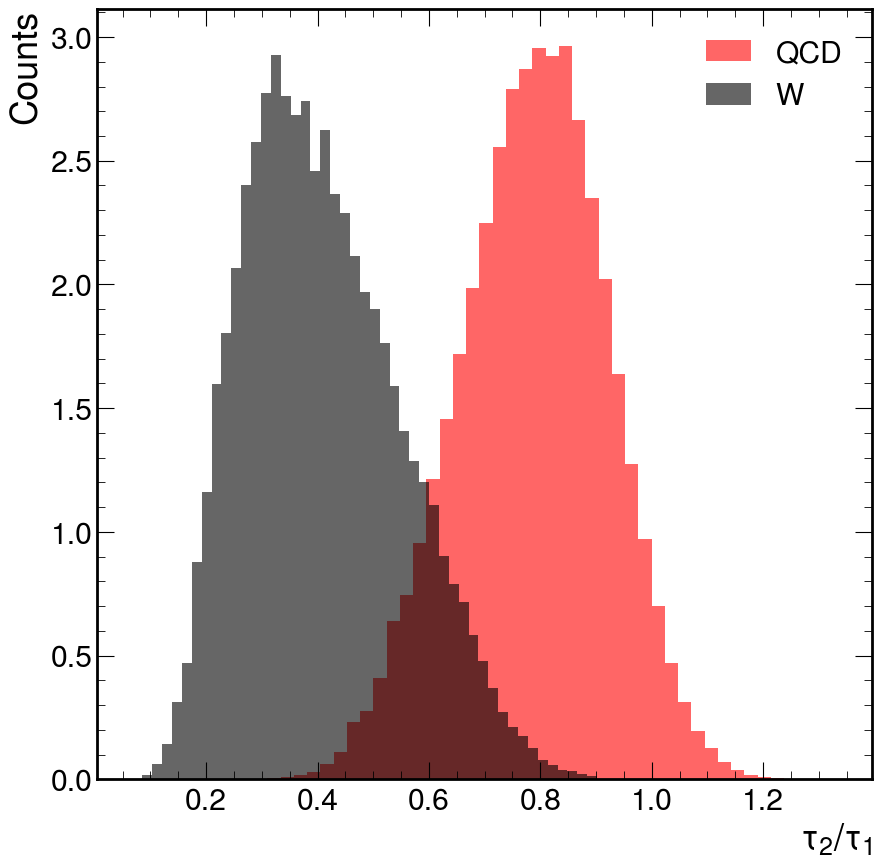

In [5]:
##Plotting function between qcd background and the W signal
def plot_tau21_dt():
    
    #Lets Look at the mass
    weights = [1000*18300, "puweight", "scale1fb"]

    qcdsel      = selection(qcd)
    wsel        = selection(wqq13)

    wscale=scale(wqq,wqq13,weights) #retrieving the energy scale of integra(wqq)/integral(wqq13)

    # Getting the masses of selected events

    #Background
    qcd_t21  = (qcd.arrays('vjet0_t2', library="np")['vjet0_t2'][qcdsel]/
               qcd.arrays('vjet0_t1', library="np")['vjet0_t1'][qcdsel])
    qcd_jetptnocut = (qcd.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())[qcdsel]
    qcd_jetmass  =   (qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())[qcdsel]
    qcd_rho = np.log(qcd_jetmass**2/qcd_jetptnocut)
    qcd_t21_dt = qcd_t21 - (-0.089) * qcd_rho

    w_t21    = (wqq13.arrays('vjet0_t2', library="np")['vjet0_t2'][wsel]/
               wqq13.arrays('vjet0_t1', library="np")['vjet0_t1'][wsel])
    w_jetptnocut = (wqq13.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
    w_jetmass  =   (wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
    w_rho = np.log(w_jetmass**2/w_jetptnocut)
    w_t21_dt = w_t21

    plt.hist(qcd_t21_dt,
             weights=get_weights(qcd,weights,qcdsel),
             bins=50,
             color='red',
             label="QCD", alpha=.6, density = True)
    
    plt.hist(w_t21_dt,
             weights=get_weights(wqq13,weights,wsel)*wscale,
             bins=50,
             color='black',
             label="W", alpha=.6, density = True)

    #Other configurations for the histogram
    plt.legend()
    plt.xlabel(r"$\tau_{2}/\tau_{1}$")
    plt.ylabel("Counts")
    plt.show()

plot_tau21_dt()

We see here by plotting the T2/T2_dt distribution for QCD(background) and W(signal) that by using the docorrelated taggers, the T2/T1 distributions are much better seperated. Eyeballing it, we can select a threshold of ~`0.5` to select much more signal jets than background jets.

In [168]:
def selectionW(iData, t21dt_threshold = 0.5):
    '''
    This is the specific selection for selecting out events with W signal for our analysis
    '''
    
    #Pre-selection citeria
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
    jetptnocut = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
    jetmass = (iData.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
    jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
    jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
    
    
    #Define the two parameters rho and tau2/tau1 
    rho = np.log(jetmass**2/jetptnocut) ### YOUR CODE HERE ###
    t21 = jett2/jett1 ### YOUR CODE HERE ###
    t21ddt = t21 - (-0.089)*rho ### YOUR CODE HERE ###
                            
    #And then perform the cut
    #Hint: You could determine the threshold of the cut by plotting the distribution of 
    #t21ddt scores for W and background and then determine a ball park threshold
    #where you think the W signal would be best selected
    t21cut   = t21ddt < t21dt_threshold ### YOUR CODE HERE ###
    
    allcuts = np.logical_and.reduce([trigger, jetpt, t21cut])
    
    return allcuts

-----

Now that we have our selection function, let's try to make the mass plot!

/var/folders/zl/fqyfw3z95bjccqn0m2sm7qhw0000gn/T/ipykernel_61603/422657785.py:16: RuntimeWarning: divide by zero encountered in log
  rho = np.log(jetmass**2/jetptnocut) ### YOUR CODE HERE ###


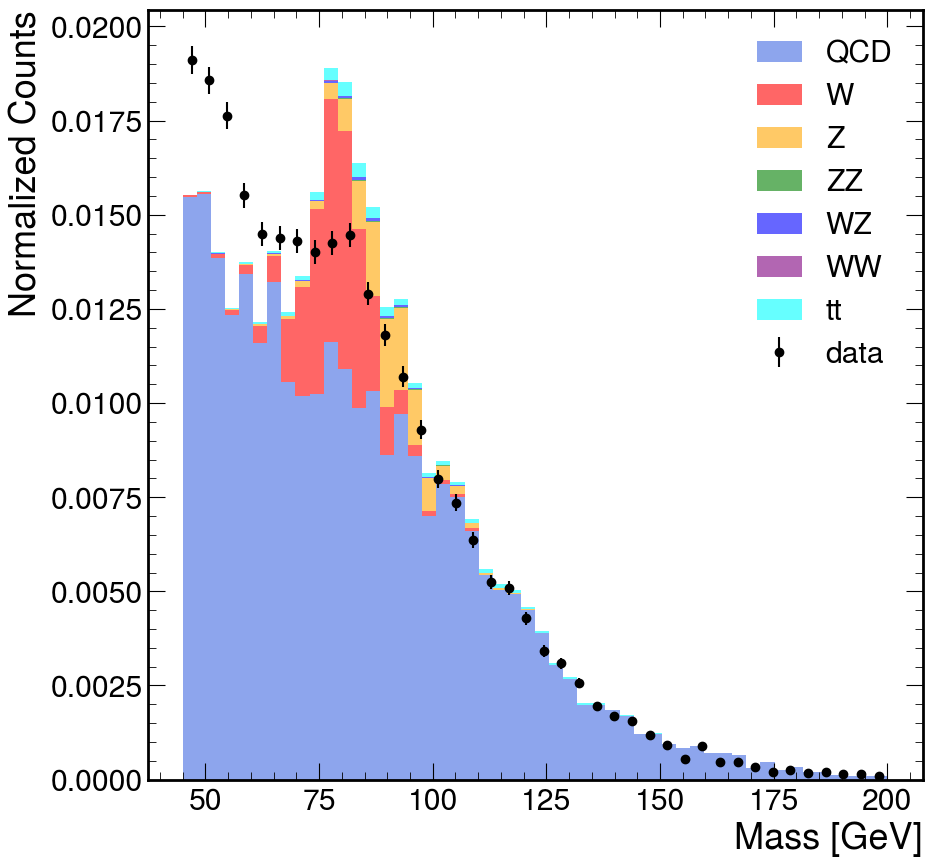

In [47]:
#Lets Look at the mass
weights = [1000*18300, "puweight", "scale1fb"]
mrange = (45,200)  #range for mass histogram [GeV]
bins=40            #bins for mass histogram
density = True     #to plot the histograms as a density (integral=1)

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = selectionW(zqq13)
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = selectionW(ww)
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzW = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzW = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwW = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttW = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gghW = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

plt.hist([qcdW,wW, zW, zzW, wzW, wwW, ttW], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan",], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt",], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)

counts, bins = np.histogram(dataW, bins=bins, range=mrange, density=density)
yerr = np.sqrt(counts) / np.sqrt(len(dataW)*np.diff(bins))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

Remember to compare your mass plot with the one given above!

## 1.2 W Peak Fit

In this section you will perform the fit on W signal. It involves a few steps:
    
1. First you need to define a fit model of your own. In this case we would use some functions (gaussian, exponential) in conjuntion with a 6th order polynomial. You could see more on how the order of the polynomials are determined here: https://en.wikipedia.org/wiki/Chow_test. The concepts were also covered in Lecture 8-9 if you want to review it. Later on you will have the chance to determine the order of the polynomial for the Z fit. You might see that we might not necessarily need a 6th order polynomial for the Z fit. The main reason for this is that we have much more data in W sample than the Z sample.

In [147]:
def fitW(x,amp, mu, std, p0, p1, p2, p3, p4, p5, p6):
    '''
    You should define other functions in conjunction with a 6th order polynomial
    '''
    
    ## Signal bump
    signal = np.exp(-0.5 * ((x - mu) / std)**2)

        
    # ## Exponential decay if we need this
    # def expo_decay(x, b, c):
    #     return b*np.exp(c * x)

    ## Background 6th order polynomial
    background = p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5 + p6 * x**6

    ## Combined model
    return amp * signal + background


2. After defining your model, you need to get the data histogram and perform the fit:

[[Model]]
    Model(fitW)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 40
    # variables        = 10
    chi-square         = 25.8973369
    reduced chi-square = 0.86324456
    Akaike info crit   = 2.61042749
    Bayesian info crit = 19.4992220
    R-squared          = 0.99696255
[[Variables]]
    amp:  227.991435 +/- 65.7345424 (28.83%) (init = 3690)
    mu:   81.6288217 +/- 1.19521832 (1.46%) (init = 80)
    std:  9.00139204 +/- 1.76601561 (19.62%) (init = 5)
    p0:  -14162.7218 +/- 7548.11142 (53.30%) (init = 747.75)
    p1:   1265.33075 +/- 561.957065 (44.41%) (init = 0)
    p2:  -39.9747137 +/- 16.7225467 (41.83%) (init = 0)
    p3:   0.63330174 +/- 0.25605290 (40.43%) (init = 0)
    p4:  -0.00540737 +/- 0.00214326 (39.64%) (init = 0)
    p5:   2.3751e-05 +/- 9.3453e-06 (39.35%) (init = 0)
    p6:  -4.2135e-08 +/- 1.6631e-08 (39.47%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)   = -0

25.897336911585473

<Figure size 1000x1000 with 0 Axes>

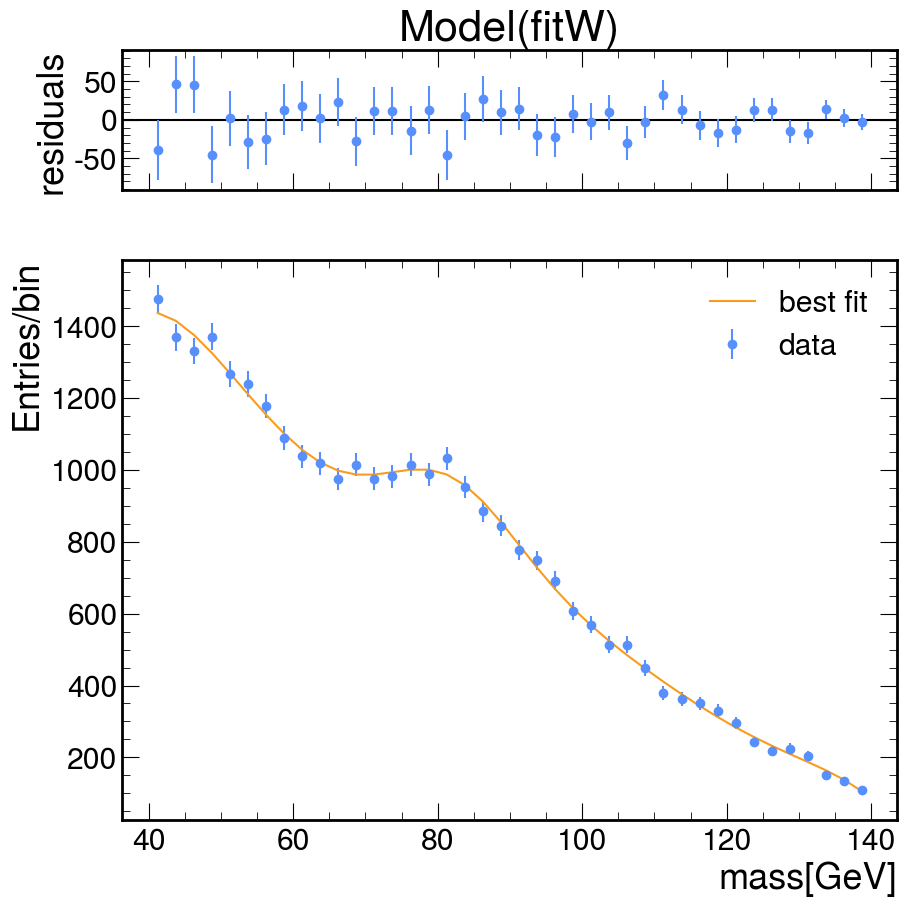

In [148]:
# Now we get the data histogram so we can fit it
bins = 40
mrange=[40,140]
counts, bins = np.histogram(dataW,bins=bins,range=mrange,density=False)
counts = np.where(counts == 0, 1e-10, counts)
w = 1/ np.sqrt(counts) #poisson unc) #Poisson uncertainty here
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

#Perform the fit 
model = lm.Model(fitW)
p = model.make_params()

#For better fit I suggest adding restrictions to the fit.
p['mu'].set(80, min=75, max=85, vary =True)
p['amp'].set(np.max(counts) *(bins[1] - bins[0]), min = 0, vary=True)
p['std'].set(5, min=3, max=10,vary = True)
# p['b'].set(np.mean(counts), vary = True)
# p['c'].set(-3, vary=True)
p['p0'].set(np.mean(counts), vary = True)
p['p1'].set(0, vary = True)
p['p2'].set(0, vary = True)
p['p3'].set(0, vary = True)
p['p4'].set(0, vary = True)
p['p5'].set(0, vary = True)
p['p6'].set(0, vary = True)


result_W = model.fit(data=y,
                    params=p,
                    x=x,
                    weights=w)

#Plot the result
plt.figure()
result_W.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))

#Print the fit summary
print(result_W.fit_report())
result_W.chisqr

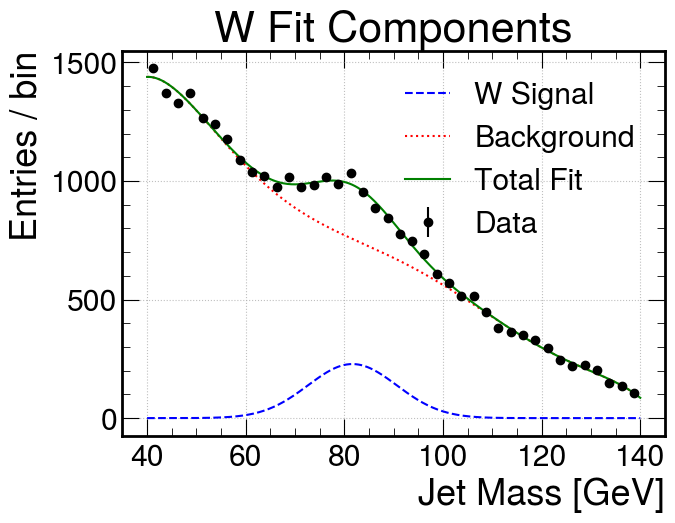

In [149]:
# Separate signal and background plots to see
xplot = np.linspace(40, 140, 500)
best_vals = result_W.best_values
signal = best_vals['amp'] * np.exp(-(xplot - best_vals['mu'])**2 / (2 * best_vals['std']**2))
background = sum(best_vals[f'p{i}'] * xplot**i for i in range(7))

plt.figure(figsize=(7,5))
plt.errorbar(x, y, yerr=w, fmt='o', label="Data", color="black")
plt.plot(xplot, signal, label="W Signal", color="blue", linestyle="--")
plt.plot(xplot, background, label="Background", color="red", linestyle=":")
plt.plot(xplot, signal + background, label="Total Fit", color="green")
plt.xlabel("Jet Mass [GeV]")
plt.ylabel("Entries / bin")
plt.title("W Fit Components")
plt.legend()
plt.grid(True)
plt.show()


We have done the initial fits with a gaussian as the W signal and 6th order polynomial as the background. 


Remember to compare your fit plot! Now we need to extract the W mass and the error in the measurement!

In [150]:
mW = result_W.params["mu"].value
mWerr = result_W.params["mu"].stderr

print(f'The mass of the W boson from the fit is {mW:.2f} GeV ± {mWerr:.2f}')
print(f'The true/best measurement of the mass of the W boson is {80.43:2f} GeV')
print(f'The reduced chi square associated with this fit is {result_W.redchi:.2f}')


The mass of the W boson from the fit is 81.63 GeV ± 1.20
The true/best measurement of the mass of the W boson is 80.430000 GeV
The reduced chi square associated with this fit is 0.86


Your **W mass should be in the 80-90 GeV** range depending on the fit function of your choice!

----

# 2. Fit for Z peak

**NOTE: It is not mandatory that you completely finish this section before turning your work in!**

Now that you have done the W fit, the next challenge is to see whether you can also perform the Z fit! They are very similar in concepts. However, the selection for Z requires a special cut: **the deep double-b tagging score (ddb).** This is because unlike the W, Z can decays into two b quarks and hence a cut on this score would remove many W signals. 

The codes to perform the fit should be very similar to what we have shown you in the last section! Your plots should come out similarly to this in the end:

<img src="images/S50_ZFit.png" width='900'>

First, let's try to re-write the selection function. Remember that you now need to add the deep double b score of the jet and place a cut on it. The inividual b score in each subjet is already given in the `vjet0_sj1_csv` and `vjet0_sj2_csv` variable, how would you compute the b score of the whole jet?

Another hint for placing the cut is this following table: 

<img src="images/S50_ZBtagCut.png" width='500'>

You could just ignore the labelling for the most part, the main point here is that there are three "operating" or "working" points: tight, medium, loose. Each according to specific cuts on the **individual** subjet b score. For example, a mistag rate of 0.1 would require the b score to be more than 0.9. The tight working point is also what is generally used. Using this information could you pick an appropriate threshold for the whole jet?

An alternative approach to experimenting with different working points is for you to plot the distribution of the b scores of the Z signal versus W and QCD like we did in Section 0. From the histogram we could determine the appropriate cut.

To understand the T21_dt distribution of the Z as compared to QCD and W, let's try to plot it the decorrelated n-subjettiness again.

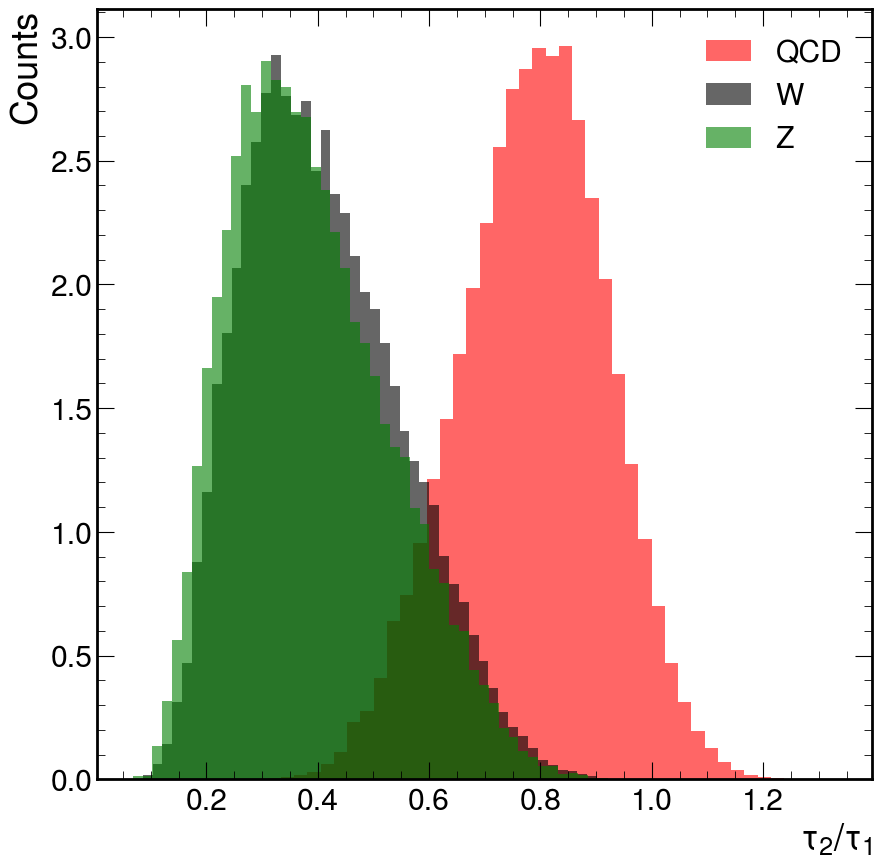

In [106]:
## Let's try to plot the T2/T1_dt of the Z data and let's try to compare it with the W and the QCD data
##Plotting function between qcd background and the W signal
def plot_tau21_dt():
    
    #Lets Look at the mass
    weights = [1000*18300, "puweight", "scale1fb"]

    qcdsel      = selection(qcd)
    wsel        = selection(wqq13)
    zsel        = selection(zqq13)
    
    wscale=scale(wqq,wqq13,weights) #retrieving the energy scale of integra(wqq)/integral(wqq13)
    zscale=scale(zqq,zqq13, weights )
    # Getting the masses of selected events

    #Background
    qcd_t21  = (qcd.arrays('vjet0_t2', library="np")['vjet0_t2'][qcdsel]/
               qcd.arrays('vjet0_t1', library="np")['vjet0_t1'][qcdsel])
    qcd_jetptnocut = (qcd.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())[qcdsel]
    qcd_jetmass  =   (qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())[qcdsel]
    qcd_rho = np.log(qcd_jetmass**2/qcd_jetptnocut)
    qcd_t21_dt = qcd_t21 - (-0.089) * qcd_rho

    #W data
    w_t21    = (wqq13.arrays('vjet0_t2', library="np")['vjet0_t2'][wsel]/
               wqq13.arrays('vjet0_t1', library="np")['vjet0_t1'][wsel])
    w_t21_dt = w_t21

    #Z_data
    z_t21    = (zqq13.arrays('vjet0_t2', library="np")['vjet0_t2'][zsel]/
               zqq13.arrays('vjet0_t1', library="np")['vjet0_t1'][zsel])
    z_t21_dt = z_t21

    plt.hist(qcd_t21_dt,
             weights=get_weights(qcd,weights,qcdsel),
             bins=50,
             color='red',
             label="QCD", alpha=.6, density = True)
    
    plt.hist(w_t21_dt,
             weights=get_weights(wqq13,weights,wsel)*wscale,
             bins=50,
             color='black',
             label="W", alpha=.6, density = True)
    
    plt.hist(z_t21_dt,
            weights=get_weights(zqq13,weights,zsel)*zscale,
            bins=50,
            color='green',
            label="Z", alpha=.6, density = True)

    #Other configurations for the histogram
    plt.legend()
    plt.xlabel(r"$\tau_{2}/\tau_{1}$")
    plt.ylabel("Counts")
    plt.show()

plot_tau21_dt()

From the above distibution, we see that the decorrelated n-subjettiness(T21_dt) of the Z and W signals are sufficiently close. Therefore, we are not able to use the T21_dt cut to significantly distinguish between the Z and the W signals, but it does distinguish between signals and QCD background.

To distinguish Z and W signals, we can use the double b scores of the jets. To do that, let's plot the double B scores of the QCD, Z and W data.


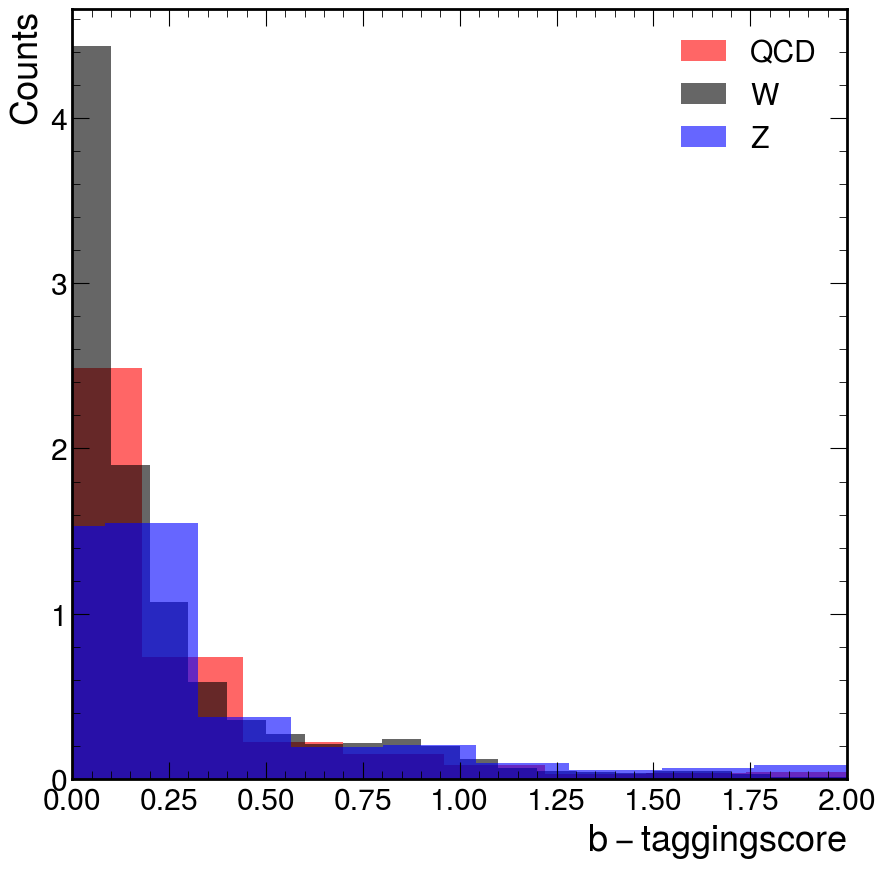

In [151]:
def plot_Dbb_():

    qcdsel      = selection(qcd)
    wsel        = selection(wqq13)
    zsel        = selection(zqq13)
    
    wscale=scale(wqq,wqq13,weights) #retrieving the energy scale of integra(wqq)/integral(wqq13)
    zscale=scale(zqq,zqq13, weights )

    # Getting the masses of selected events

    #Background
    qcd_jetcsvsj1  = (qcd.arrays('vjet0_sj1_csv', library="np")["vjet0_sj1_csv"].flatten())
    qcd_jetcsvsj2  = (qcd.arrays('vjet0_sj2_csv', library="np")["vjet0_sj2_csv"].flatten())
    qcd_b_scores   = qcd_jetcsvsj1 + qcd_jetcsvsj2

    #W data
    w_jetcsvsj1  = (wqq13.arrays('vjet0_sj1_csv', library="np")["vjet0_sj1_csv"].flatten())
    w_jetcsvsj2  = (wqq13.arrays('vjet0_sj2_csv', library="np")["vjet0_sj2_csv"].flatten())
    w_b_scores   = w_jetcsvsj1 + w_jetcsvsj2

    #Z_data
    z_jetcsvsj1  = (zqq13.arrays('vjet0_sj1_csv', library="np")["vjet0_sj1_csv"].flatten())
    z_jetcsvsj2  = (zqq13.arrays('vjet0_sj2_csv', library="np")["vjet0_sj2_csv"].flatten())
    z_b_scores   = z_jetcsvsj1 + z_jetcsvsj2

    plt.hist(qcd_b_scores[qcdsel],
            weights=get_weights(qcd,weights,qcdsel),
            bins=50,
            color='red',
            label="QCD", alpha=.6, density = True)
    
    plt.hist(w_b_scores[wsel],
            weights=get_weights(wqq13,weights,wsel)*wscale,
            bins=50,
            color='black',
            label="W", alpha=.6, density = True)
    
    plt.hist(z_b_scores[zsel],
            weights=get_weights(zqq13,weights,zsel)*zscale,
            bins=50,
            color='blue',
            label="Z", alpha=.6, density = True)

    #Other configurations for the histogram
    plt.xlim(0,2)
    plt.legend()
    plt.xlabel(r"$b-tagging score$")
    plt.ylabel("Counts")
    plt.show()

plot_Dbb_()


We see from the above b distribution of QCD background, Z, and W data and can infer that an initial cut for individual score of > 0.9 to be quite reasonable. This would mean a double b threshold of 1.8. We can change this to assess for better results.


In [120]:
# Let's define a selection that will keep Z jets and remove background.
def selectionZ(iData, dbb_threshold = 1.8):
    
        #Standard preselection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
        
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
        jetmass = (iData.arrays('vjet0_msd0', library="np")["vjet0_msd0"].flatten())
        jett2   = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"].flatten())
        jett1   = (iData.arrays('vjet0_t1', library="np")["vjet0_t1"].flatten())
        jetptnocut = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten())
        jetcsvsj1  = (iData.arrays('vjet0_sj1_csv', library="np")["vjet0_sj1_csv"].flatten())
        jetcsvsj2  = (iData.arrays('vjet0_sj2_csv', library="np")["vjet0_sj2_csv"].flatten())
        
        # Following the same procedure as https://arxiv.org/pdf/1603.00027.pdf
        # we select 2 progned jets (since W and Z primarily decay to 2 quarks)
        # we correct t21 to minimize the dependance on m and pt
        rho = np.log(jetmass**2/jetptnocut) ### YOUR CODE HERE ###
        t21 = jett2/jett1 ### YOUR CODE HERE ###
        
        t21ddt = t21 - (-0.089)* rho ### YOUR CODE HERE ###
        t21cut = t21ddt < 0.6 ### YOUR CODE HERE ### #You could use a similar cut to W, but looser
        
        # this cut keeps jets with subjet 1 and subjet 2 coming from a secondary vertex
        # i.e. the subjets originate from a displaced particle (namely a b quark)
        # Unlike W bosons, the Z can decay into 2 b quarks which is why this selection removes 
        # many W jets.
        ddb = jetcsvsj1 + jetcsvsj2 ### YOUR CODE HERE ###
        ddbcut = ddb > dbb_threshold ### YOUR CODE HERE ###
        
        allcuts = np.logical_and.reduce([trigger,jetpt, t21cut, ddbcut])
        
        return allcuts

Similar to the W, let's try to make the mass plot first to see if we get the correct mass plot:

## 2.1 Z mass plot

We can basically just reused what we had in the last section

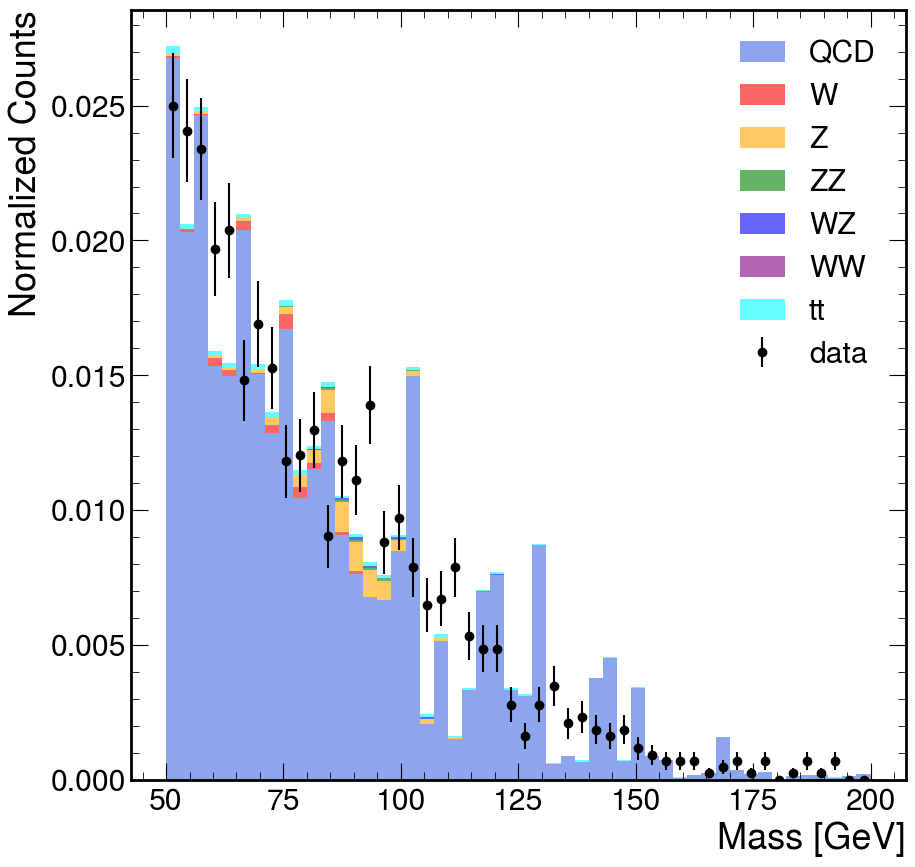

In [121]:
# Some default parameters
weights=[1000*18300,"puweight","scale1fb"]
mrange = (50,200) #range for mass histogram [GeV]
bins=50           #bins for mass histogram
density = True    #to plot the histograms as a density (integral=1)

# Selecting data and MC 
qcdsel      = selectionZ(qcd)
wsel        = selectionZ(wqq13)
zsel        = selectionZ(zqq13)
datasel     = selectionZ(data)
ttsel       = selectionZ(tt)
wwsel       = selectionZ(ww)
wzsel       = selectionZ(wz)
zzsel       = selectionZ(zz)
gghsel      = selectionZ(ggh)

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

# Getting the masses of selected events
datat21 = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdt21 = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wt21 = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zt21 = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzt21 = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzt21 = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwt21 = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttt21 = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gght21 = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

# Proper weights for each histogram
hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

# Plot stacked histograms
plt.hist([qcdt21,wt21, zt21, zzt21, wzt21, wwt21, ttt21], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan"], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt"], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)
counts, bins = np.histogram(datat21,bins=bins,range=mrange,density=density)

# Getting the proper err requires normalizing since we are using a density not the actual count
yerr = np.sqrt(counts) / np.sqrt(len(datat21)*(np.diff(bins))) 
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

The mass plot we have obtained is pretty similar to the plot we have been provided.

## 2.1 Fit for Z peak

Now, adapting the codes provided for you in the W section, perform a fit to the Z peak and extract its mass! The concept is similar to our previous W fit, but this time I would let you explore what fit function would be appropriate in this case.

In [152]:
def fitZ(x, amp, mu, std, p0, p1, p2, p3, p4, p5, p6):
    '''
    You should define other functions in conjunction with a 6th order polynomial
    '''
    
    ## Signal bump
    signal = np.exp(-0.5 * ((x - mu) / std)**2)

    # ## Exponential decay if we need this
    # def expo_decay(x, b, c):
    #     return b*np.exp(c * x)

    ## Background 6th order polynomial
    background = p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5 + p6 * x**6

    ## Combined model
    return amp * signal + background


----

Then, get the data histogram and perform the fit

[[Model]]
    Model(fitZ)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1356
    # data points      = 40
    # variables        = 10
    chi-square         = 24.7399010
    reduced chi-square = 0.82466337
    Akaike info crit   = 0.78151642
    Bayesian info crit = 17.6703110
    R-squared          = 0.97366985
[[Variables]]
    amp:  17.2157044 +/- 11.4529310 (66.53%) (init = 282.5)
    mu:   92.7242805 +/- 0.70165056 (0.76%) (init = 91)
    std:  1.50000000 +/- 0.79409900 (52.94%) (init = 5)
    p0:  -1560.42899 +/- 1270.37203 (81.41%) (init = 45.1)
    p1:   127.075945 +/- 95.6921780 (75.30%) (init = 0)
    p2:  -3.75693776 +/- 2.90157734 (77.23%) (init = 0)
    p3:   0.05538017 +/- 0.04541701 (82.01%) (init = 0)
    p4:  -4.3732e-04 +/- 3.8786e-04 (88.69%) (init = 0)
    p5:   1.7673e-06 +/- 1.7176e-06 (97.19%) (init = 0)
    p6:  -2.8681e-09 +/- 3.0887e-09 (107.69%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(p5, p6)   = -

<Figure size 1000x1000 with 0 Axes>

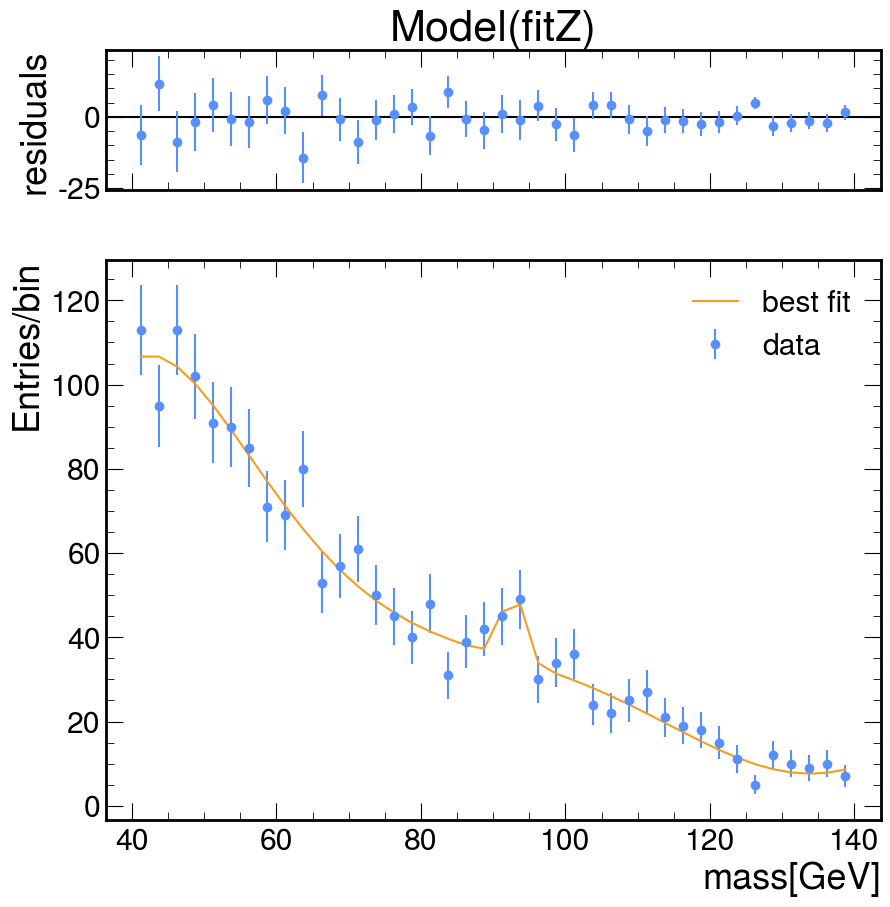

In [155]:
# Now we get the data histogram so we can fit it
bins = 40
mrange=[40,140]
counts, bins = np.histogram(datat21,bins=bins,range=mrange,density=False)
counts = np.where(counts == 0, 1e-10, counts)
w = 1/ np.sqrt(counts) #poisson unc) #Poisson uncertainty here
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

#Perform the fit 
model = lm.Model(fitZ)
p = model.make_params()

#For better fit I suggest adding restrictions to the fit.
p['mu'].set(91, min=85, max=96, vary =True)
p['amp'].set(np.max(counts) *(bins[1] - bins[0]), min = 0, vary=True)
p['std'].set(5, min=1.5, max=10, vary=True)
# p['b'].set(np.mean(counts), vary = True)
# p['c'].set(-3, vary=True)
p['p0'].set(np.mean(counts), vary = True)
p['p1'].set(0, vary = True)
p['p2'].set(0, vary = True)
p['p3'].set(0, vary = True)
p['p4'].set(0, vary = True)
p['p5'].set(0, vary = True)
p['p6'].set(0, vary = True)


result_Z = model.fit(data=y,
                    params=p,
                    x=x,
                    weights=w)

#Plot the result
plt.figure()
result_Z.plot()
plt.xlabel("mass[GeV]", position=(0.92,0.1))
plt.ylabel("Entries/bin", position=(0.1,0.84))

#We could also check out all the fit parameters
print(result_Z.fit_report())

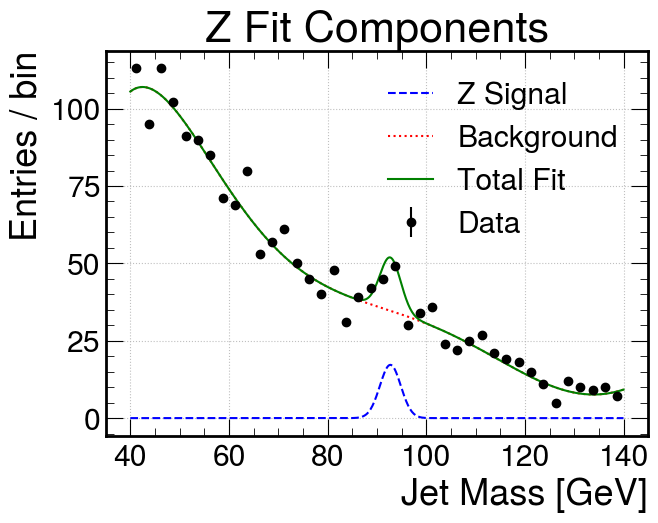

In [158]:
# Separate signal and background
xplot = np.linspace(40, 140, 500)
best_vals = result_Z.best_values
signal = best_vals['amp'] * np.exp(-0.5*(xplot - best_vals['mu'])**2 / (2 * best_vals['std']**2)) 
background = sum(best_vals[f'p{i}'] * xplot**i for i in range(7))

plt.figure(figsize=(7,5))
plt.errorbar(x, y, yerr=w, fmt='o', label="Data", color="black")
plt.plot(xplot, signal, label="Z Signal", color="blue", linestyle="--")
plt.plot(xplot, background, label="Background", color="red", linestyle=":")
plt.plot(xplot, signal + background, label="Total Fit", color="green")
plt.xlabel("Jet Mass [GeV]")
plt.ylabel("Entries / bin")
plt.title("Z Fit Components")
plt.legend()
plt.grid(True)
plt.show()


After the fit we can extract the Z mass and the error in our measurement.

In [161]:
mZ = result_Z.params["mu"].value
mZerr = result_Z.params["mu"].stderr

print(f'The mass of the Z boson from the fit is {mZ:.2f} GeV ± {mZerr:.2f} GeV')
print(f'The true/best measurement of the mass of the Z boson is {91.188:.2f} GeV')
print(f'The reduced chi square associated with this fit is {result_Z.redchi:.2f}')

The mass of the Z boson from the fit is 92.72 GeV ± 0.70 GeV
The true/best measurement of the mass of the Z boson is 91.19 GeV
The reduced chi square associated with this fit is 0.82


Note that the Z mass should be around **91 GeV**.

-----

# 3. Weak mixing angle (OPTIONAL)

# If you have both W and Z boson, you can measure a fundamental parameter of the standard model. The Weak mixing angle, sometimes referred to as the Weinberg angle. 

<font color="blue"> From your measurement of the W and Z boson mass come up with a measurement of the W and Z boson mixing angle.  </font>

we have that $\sin^2\theta_w = 1 - (\frac{m_W}{m_Z})^2$ which was measured to be about 0.231. 


Using the masses we measured and propagating the error gives |

In [169]:
sin2theta = 1 - (mW/mZ)**2

# Error propagation
dxdmW = 2 * mW / mZ**2
dxdmZ = -2 * mW**2 / mZ**3
sin2theta_err = np.sqrt((dxdmW * mWerr)**2 + (dxdmZ * mZerr)**2) ### YOUR CODE HERE ###

print(f"sin^2(theta) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")
print(f'Best value of the weak mixing angle: {0.231}')

sin^2(theta) = 0.225 +\- 0.026
Best value of the weak mixing angle: 0.231


-----

# Report: W and Z Boson Mass Fits

## **Explanation of the Procedure**

The procedure isolates W and Z boson signals from the real data, leveraging selection criteria and fitting techniques to measure their masses. The key components are:

1. **Data Selection:**
- A standard pre-selection function `selection` requires a positive trigger `trigger > 0` and jet transverse momentum `vjet0_pt > 400 GeV`, ensuring high-energy jet events typical in high-energy physics analyses.
- For W boson selection, we need to seperate W signals from the QCD background. To do that we employ the n-subjettines `tau2/tau1` of each jet keeping in mind that that the n-subjettiness of signal jets are lower than the QCD jets.
- For more effective seperation using the n-subjettiness, we decorrelate the value of `tau21` using the `rho` value that is as `log(m**2/jetpt)` and the correlation of `tau21` and `rho` to define the new value of `tau21_dt` and then define a function `selectionW` by adding a cut of `tau21_dt < 0.5`.
- For the Z bosons, we use the `double_b_scores` of the jets and implement the extra cut so as to seperate Z signals from W signals and define the function `selectionZ` with the cut `Dbb > 1.8`.
- Then the fits for W and Z are done by doing their respective selection on the true data we have. 

3. **Fitting Model:**
- The signal is modeled as a Gaussian distribution, parameterized by mean ($\mu$, mass), standard deviation ($\sigma$, width), and amplitude.
- A 6th-order polynomial models the smooth background, primarily QCD, accommodating its complex shape.
- The lmfit package minimizes the chi-square statistic, fitting the combined signal+background model to data histograms and accounting for bin uncertainties.


## **Results and Significance**

The W and Z boson mass fits yield the following results, supported by plots in the notebook (Sections 2.1 and 2.2):

1. **W Boson Fit**
 - The mass of the W boson from the fit is `81.63 GeV ± 1.20` with the true value being `80.43 GeV`. 
 - The reduced chisquare for this fit was `0.86` suggesting a sufficiently good fit.
 - The fitted mass of the W boson is a bit higher than the expected value. 

2. **Z Boson Fit:**
- The mass of the Z boson from the fit is `92.72 GeV ± 0.70 GeV` with the true value being `91.19 GeV`. 
- The reduced chi square associated with this fit is `0.82` suggesting an okay fit.
- The fitted mass of the Z boson is a bit bigger than the expected value. 

3. **Weak Mixing Angle**
- We have the weak mixing angle from the fit as `sin^2(theta) = 0.225 +\- 0.026` with the true value being `0.231`.
- Although the true value of the mixing angle is within statistical reach of our fit value, we can that that our fit is not the ideal suggesting the need for further improvements.

## **Further Improvements**
- In our fits, we have overestimated the mass of the W boson because many of the "signal" events selected by `selectionW` contain a Z boson which has higher mass.  - Because we can't easily find a selection that removes Z jets and keeps W jets we will resort to making a correction from the Monte Carlo (MC). 
- Since we have control over what samples go into the MC we can actually do our fit with and without Z jets to see how biased our procedure is. Then we can correct for this bias approriately.





# 4. Correcting $m_W$   ( OPTIONAL)

First we need to perform the selection for W again

In [7]:
#Lets Look at the mass
weights = [1000*18300, "puweight", "scale1fb"]
mrange = (45,200)  #range for mass histogram [GeV]
bins=40            #bins for mass histogram
density = True     #to plot the histograms as a density (integral=1)

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = selectionW(zqq13)
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = selectionW(ww)
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzW = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzW = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwW = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttW = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gghW = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

After that we could evaluate the MC simulation in two cases:

1. MC with Z
2. MC without Z

And then based on the fit of these two samples, we could evaluate the ratio of the fitted W mass and determine the bias factor, which can then be used to correct the W mass!

In this lab we can perform a simple procedure to determine the bias by plotting the MC distribution of the W mass with selection. After that, we could take the mean and standard deviation with and without the Z to feed into our bias calculation! A more advanced approach would be to perform the whole W fit again with QCD MC. However, the fit is rather hard to control (getting a good $\chi^2$ is hard). Therefore, for the purposes of this course, we would resort to a simpler verion first!

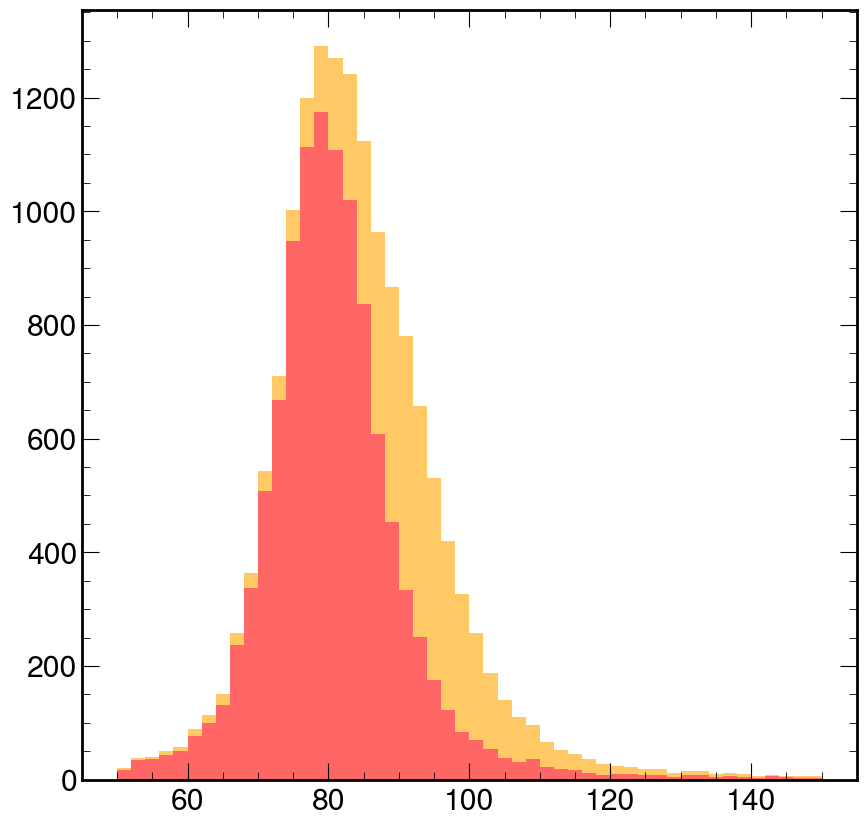

W mass with Z: 84.05878330375637. W mass without Z: 80.75567630536186
W mass (standard deviation) with Z: 11.83245895178741. W mass (standard deviation) without Z: 10.30748357847142


In [8]:
bins=50

# We need the weights from our MC
wweights = get_weights(wqq13,weights,wsel)*wscale
zweights = get_weights(zqq13,weights,zsel)*zscale
qcdweights = get_weights(qcd,weights,qcdsel)

mrange = [50,150]

# Now we stack the histograms into a single density 
counts_mc, bins,_ = plt.hist([wW,zW],bins=bins,range=mrange,
                             density=False,stacked=True,
                             color=["r", "orange"],
                             alpha=.6,
                             weights= [wweights, zweights])


binCenters = (bins[1:]+bins[:-1])*.5
plt.show()

mW_mc_withZ = np.average(binCenters, weights=counts_mc[-1])
mWerr_mc_withZ = np.sqrt(np.average((binCenters - mW_mc_withZ)**2, weights=counts_mc[-1]))

mW_mc_noZ = np.average(binCenters,weights=counts_mc[0])
mWerr_mc_noZ = np.sqrt(np.average((binCenters - mW_mc_noZ)**2, weights=counts_mc[0]))

print("W mass with Z: {}. W mass without Z: {}".format(mW_mc_withZ, mW_mc_noZ))
print("W mass (standard deviation) with Z: {}. W mass (standard deviation) without Z: {}".format(mWerr_mc_withZ, mWerr_mc_noZ))

Then we can obtain the mass with no Z in the sample:

In [ ]:
bins=28

# We need the weights from our MC
qcdweights = get_weights(qcd,weights,qcdsel)
wweights =get_weights(wqq13,weights,wsel)*wscale


# Now we stack the histograms into a single density 
# so we can fit bkg+signal
counts_mc, bins,_ = plt.hist([qcdW,wW],
                             bins=bins,
                             range=mrange,
                             density=True,
                             stacked=True,
                             color=["royalblue","r"],
                             alpha=.6,
                             weights= [qcdweights, wweights])

binCenters = (bins[1:]+bins[:-1])*.5
plt.show()

mW_mc_withnoZ = np.average(binCenters, weights=counts_mc[-1])
mWerr_mc_withnoZ = np.sqrt(np.average((binCenters - mW_mc_withnoZ)**2, weights=counts_mc[-1]))

mW_mc_noZ = np.average(binCenters,weights=counts_mc[0])
mWerr_mc_noZ = np.sqrt(np.average((binCenters - mW_mc_noZ)**2, weights=counts_mc[0]))

print("W mass with Z: {}. W mass without Z: {}".format(mW_mc_withZ, mW_mc_noZ))
print("W mass (standard deviation) with Z: {}. W mass (standard deviation) without Z: {}".format(mWerr_mc_withZ, mWerr_mc_noZ))


## 4.3 Bias factor and correct for W mass

Now that we obtain the W mass in both cases, let's correct for the W mass!

In [ ]:
# now we calculate our bias factor
# if the W mass measured with and without Z is the same 
# this factor should be 1
bias = mW_mc_withZ / mW_mc_noZ

#propagate the error assuming uncorrelated gaussian uncertainties
bias_err = ### YOUR CODE HERE ###

-----

In [ ]:
mW_corrected = mW/bias
mWerr_corrected = ### YOUR CODE HERE ###

-----

In [ ]:
print(f"Correcting the W mass using MC (simulated data) gives m_W = {mW_corrected:.1f} +\- {mWerr_corrected:.1f}")

In [ ]:
sin2theta = 1 - (mW_corrected/mZ)**2
sin2theta_err = ### YOUR CODE HERE ###
print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

-----

And the new $Sin^2(\theta)$ should be at around:

$$Sin^2(\theta) = 0.21$$

This measurement is much better than the previous one! Congratulations on making it this far to this lab!

Now if you have made it through this whole exercise, why don't you try to look for the Higgs boson. The Higgs boson also decays hadronically and decays predominantly to a certainy pair of particles. Take a look [here](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-higgs-boson.pdf). 
 <font color="blue"> Can you search for the Higgs boson? What is your sensitivity.  </font>

------

## 4. Search for the Higgs Boson! (OPTIONAL)